In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
env = gym.make('MountainCar-v0').unwrapped
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

## Environment visualization

Requires `torchvision` to be installed

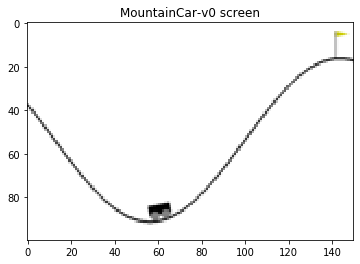

In [4]:
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

resize = T.Compose([T.ToPILImage(),
                    T.Resize(100, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    view_width = int(screen_width * 0.6)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('MountainCar-v0 screen')
plt.show()
env.close()

In [5]:
# from gym.utils.play import play
# play(gym.make('MountainCar-v0'))

# Deep Q-Network


## Q-learning

Q-learning is a process of learning action-value function $Q(s, a)$: measure of goodness of the action $a$ being in the state $s$. After the Q-learning process, algorithm provides table with Q-values, which is used to make decisions.  

Learning process is made via one-step look ahead. 

$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r_{t+1} + \gamma \max_{a'} Q(s', a') \right] $

## Deep Q-learning

Whenever the space of states and actions becomes too large, the memory and computation requirements for Q is high.  
To address that, DQN is introduced, where Deep Network approximates $Q(s,a)$.

### Model Loss

$r$ - reward for transition $(s, a) \rightarrow s'$;  
In this case, reward is potential-based: $r = r_{env} + 150 * (\gamma * \Phi(s') - \Phi(s))$, where $\Phi(s) = |h|$  


$\delta = Q(s, a) - (r + \gamma max_{a'} Q(s', a'))$  
$a'$ - largest state-action value in state $s'$

In [6]:
class DQN(nn.Module):
    """
    Simple model with 3 linear layers
    """
    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)    

In [7]:
from dataclasses import dataclass
from collections import deque
from typing import Deque, List, Tuple, Tuple
import random
from collections import namedtuple


random.seed(1337)

Transition = namedtuple('Transition', ('state', 'new_state', 'action', 'reward', 'done'))
        
# data inside will be tensors, not primitive types
@dataclass
class Batch:
    state: List[Tuple[float, float]]
    new_state: List[Tuple[float,float]]
    action: List[int]
    reward: List[int]
    done: List[bool]


# Experience Replay technique 
class ReplayMemory:
    def __init__(self, capacity: int):
        self.buffer: Deque[Transition] = deque(maxlen=capacity)
        
    def __getitem__(self, idx) -> Transition:
        return self.buffer[idx]
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def __len__(self):
        return len(self.buffer)
    
    def sample(self, batch_size) -> List[Transition]:
        return random.sample(self.buffer, batch_size)


In [8]:
def init_model():
    net, target_net = DQN(), DQN()
    net.apply(init_weights)
    target_net.load_state_dict(net.state_dict())
    target_net.eval()
    return net.to(device), target_net.to(device)

In [18]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.99
EPS_END = 0.1
EPS_DECAY = 125
TARGET_UPDATE = 25

steps_done = 0

def make_action(state):
    global steps_done
    prob = random.random()
    eps_thr = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if prob > eps_thr:
        with torch.no_grad():
            return net(state).max(-1)[1].view(1, 1) # return tensor of 1 element (int \in [0, 2])
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long) # return 


def optimization_step():
    if len(memory) < BATCH_SIZE:
        return
    
    sample: List[Transition] = memory.sample(BATCH_SIZE)
    sample = Batch(*zip(*sample)) # list of separate transitions -> batch of transition parameters
    
    states = torch.cat(sample.state)
    actions = torch.cat(sample.action)
    new_states = torch.cat(sample.new_state)
    rewards = torch.cat(sample.reward)
    non_final_mask = ~torch.cat(sample.done) # mask for those samples, which are not finished (loss of finished = 0)
    
    # Q(s, a) [state-action values of all states] = model(s)(a)
    # model(s).shape == [batch_size, 3]
    # model(s)(a).shape == [batch_size, 1]
    state_action_values = net(states).gather(1, actions)
    
    # V = max_{a'} Q(s', a')
    next_state_values = torch.zeros(BATCH_SIZE, device=device) # V(s | state == finished)
    next_state_values[non_final_mask] = target_net(new_states[non_final_mask]).max(1)[0].detach()
    next_state_values = (next_state_values * GAMMA) + rewards
    next_state_values.unsqueeze_(1)
    
    loss = F.smooth_l1_loss(state_action_values, next_state_values)

    optimizer.zero_grad()
    loss.backward()
    for param in net.parameters():
        param.grad.data.clamp_(-1, 1) # Continuation of idea behind `Clipping rewards`
    optimizer.step()
    

In [19]:
net, target_net = init_model()
optimizer = optim.RMSprop(net.parameters())
memory = ReplayMemory(5000)
durations = []

def train(episodes=100, render_enabled=False):
    pbar = tqdm(range(episodes))

    for episode in pbar:
        state = env.reset()
        width, height = state
        state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)

        done = False
        duration = 0
  
        while not done:
            if render_enabled:
                env.render()
            action = make_action(state) # should return tensor
            new_state, reward, done, _ = env.step(action.item())
            new_width, new_height = new_state
            
            
            
            modified_reward = reward + 150 * (GAMMA * abs(new_height) - abs(height)) + 1e-3 * duration # penalize for many steps
            new_state = torch.tensor(new_state, dtype=torch.float, device=device).unsqueeze(0)

            modified_reward = torch.tensor([modified_reward], device=device, dtype=torch.float)
            t_done = torch.tensor([done], device=device, dtype=torch.bool)
            
            
            memory.push(state, new_state, action, modified_reward, t_done) # experience replay
            optimization_step()
            duration += 1

            height = new_height
            state = new_state
            
            if done and new_height > 0.046: # right hill is reached
                durations.append(duration)
            
        
        # Target Network update
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(net.state_dict())            
        pbar.set_description(f'Last amount of steps: {duration}')
    env.close()
    return durations

In [20]:
durations = train(200, render_enabled=False)

Last amount of steps: 199: 100%|██████████| 200/200 [01:09<00:00,  2.87it/s]


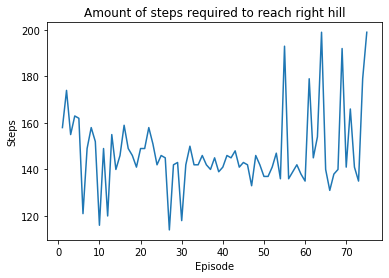

In [21]:
plt.plot(range(1, len(durations)), durations[1:])
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Amount of steps required to reach right hill')
plt.show()

## Demonstration

On my PC, I run demonstration on virtual monitor, which is connected via VNC Viewer.  
I expect it to run on a default screen, if all requirements are fulfilled.

In [22]:
from time import sleep

In [34]:
done = False
screens = []
try:
    with torch.no_grad():
        global steps_done
        steps_done = 0
        state = env.reset()
        while not done:
#             env.render()
            screens.append(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy())
            state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)

            
            action = net(state).max(-1)[1].view(1, 1).item()
            new_state, _, done, _ = env.step(action)
            state = new_state
            sleep(0.01)
finally:
    env.close()